# Using Second-Order Monochromator Transmission for Calibration

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import rootpy
import scipy

import PTI.ReadDataFiles
reload(PTI.ReadDataFiles)
from PTI.ReadDataFiles import PTIData

In [3]:
'''Interpolates between two points by taking the average of them. Returns an array twice the size'''
def interpolate_with_avg(array):
    return np.append(np.dstack((array[:-1], array[:-1] + np.diff(array)/2)).ravel(), array[-1])

# Import emission correction files
emcorr_quanta_sphere_wavelengths = np.genfromtxt("PTI/correction_data/emcorr-sphere-quanta.txt", 
                                                 skip_header = 6,
                                                 usecols = 0,
                                                 max_rows = (848-300)/2 +1)
emcorr_quanta_sphere_values = np.genfromtxt("PTI/correction_data/emcorr-sphere-quanta.txt", 
                                            skip_header = 6,
                                            usecols = 1,
                                            max_rows = (848-300)/2 +1)

emcorr_quanta_sphere_wavelengths = interpolate_with_avg(interpolate_with_avg(emcorr_quanta_sphere_wavelengths))
emcorr_quanta_sphere_values = interpolate_with_avg(interpolate_with_avg(emcorr_quanta_sphere_values))


start_wavelength = 300
end_wavelength = 650
desired_wavelengths = np.where((emcorr_quanta_sphere_wavelengths >= start_wavelength) & 
                               (emcorr_quanta_sphere_wavelengths <= end_wavelength))

emcorr_quanta_sphere_values = emcorr_quanta_sphere_values[desired_wavelengths]

We first need to find emission scans blank samples where we excite at some $\lambda_0$ and scan through some interval $I_{em}=[\lambda_i, \lambda_f]$ such that $2\lambda_0\in I_{em}$. As it turns out, the only samples that fit this criterion are the ethanol-only scans taken in August 2016 and June 2017.

In [25]:
blank_data_paths = ["Henry/Sphere/PPO_ETOH/EmissionScan_ETOH_ex310_2sec_160830.txt",
                    "Henry/Sphere/PPO_ETOH/EmissionScan_ETOH_ex320_2sec_160830.txt",
                    "Noah/Integrating Sphere Tests for PPO Contamination/EmissionScan_IS_Empty_em310_ex300-650_0x5nm_2sec_20170614_1659.txt",
                    "Noah/Integrating Sphere Tests for PPO Contamination/EmissionScan_IS_0x00gperL_PPOinETOH_ex310_em300-650_2sec_20160619.txt",
                    "Noah/Integrating Sphere Tests for PPO Contamination/EmissionScan_IS_empty_ex310_em300-650_2sec_20170621.txt",
                    "Noah/Integrating Sphere Tests for PPO Contamination/EmScan_IS_0x00gperL_PPOinETOH_ex310_em300-650_2sec_20170622_noemcorr.txt"]

ex = [310,320,310,310,310,310]

blank_data = list()
for path in blank_data_paths:
    blank_data.append(PTIData(path))
    
corrected_data = list()
for data_set in blank_data:
    baseline = data_set.get_baseline_subtracted('cor', 'linear', [[400,600]])
    emcorr = np.multiply(baseline, emcorr_quanta_sphere_values)
    corrected_data.append(emcorr)

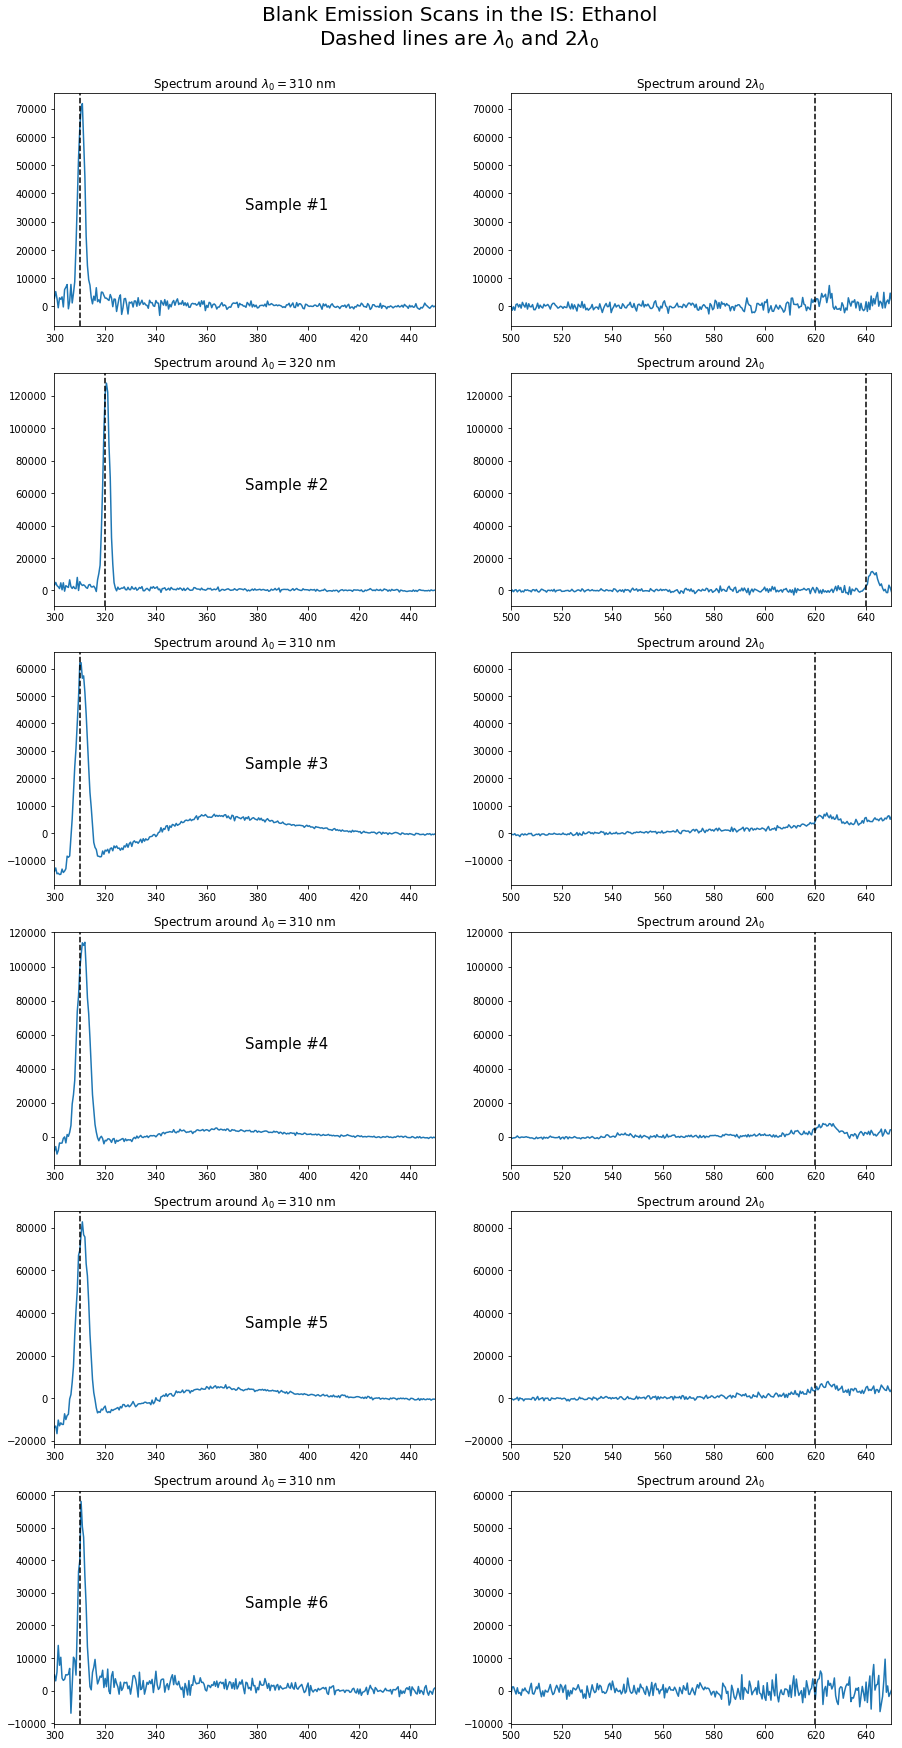

In [49]:
num_subplots = len(corrected_data)
fig = plt.figure(figsize = (15,30))
plt.suptitle("Blank Emission Scans in the IS: Ethanol\n"+
             r"Dashed lines are $\lambda_0$ and $2\lambda_0$", y=.92, fontsize=20)

for i in range(0,2*num_subplots,2):
    ax1 = fig.add_subplot(num_subplots, 2, i+1)
    ax1.plot(blank_data[i/2].wavelengths, corrected_data[i/2])
#     ax1.set_ylim([-10000, 150000])
    ax1.set_xlim([300,450])
    ax1.axvline(x=ex[i/2], ymax=1, color='k', linestyle='--')
    ax1.set_title(r'Spectrum around $\lambda_0 = $%d nm'%ex[i/2])
    ax1.text(0.5, 0.5,"Sample #" + str(i/2 +1),transform=ax1.transAxes,fontsize = 15)
    
    ax2 = fig.add_subplot(num_subplots, 2, i+2)
    ax2.plot(blank_data[i/2].wavelengths, corrected_data[i/2])
#     ax2.set_ylim([-10000, 150000])
    ax2.set_xlim([500,650])
    ax2.axvline(x=2*ex[i/2], ymax=1, color='k', linestyle='--')
    ax2.set_title(r'Spectrum around $2\lambda_0$')
    
plt.show()

**Preliminary results**: 

It appears that the secondary excitation peak appears at a larger wavelength that expected. Although it is difficult to tell when the first peak excitation peak is also off-center, Samples #1 through #3 provide evidence supporting the shift. In these samples, the incoming light has a first peak about $\lambda_0$, but the secondary peak is further left than $2\lambda_0$. 

No mention of such a shift is mentioned in *Principles of Fluorescent Spectroscopy*. More insight into the calibration of the monochromators is needed. It is possible that this analysis could allow the secondary peak to be used for calibration. 